# The Wonderful World of Numpy

https://github.com/jsheedy/intro-to-numpy

## Numpy is a Python package containing an n-dimensional array object and functions for operating on those arrays

Python has become a popular language in compute heavy fields like data science and machine learning. 

Python is an interpreted, dynamic language and as we shall see can be much slower than a compiled static language. 

Numpy allows us to leverage both the expressiveness of Python and the computational efficiency of optimized functions written in static languages without having to do any of the low level programming.

Numpy is the rock at the bottom of a large scientific computing ecosystem including

 * [Pandas](https://pandas.pydata.org/) - Data analysis kitchen sink
 * [SciPy](https://www.scipy.org/) - Scientific tools akin to Matlab packages
 * [Dask](https://dask.org/) - Parallelization system for easy big computing
 * [xarray](http://xarray.pydata.org/) - Adds metadata to numpy arrays and integration with Dask and tight netCDF integration
 * [PyViz](http://pyviz.org/) - An ecosystem of visualization packages

Understanding the fundamentals of Numpy is beneficial in using any of these tools.

### Why not use the builtin list ([]) for multidimensional data?

The list object makes it very easy to store multidimensional data, but as we'll see Numpy will often be better for speed and ease of access to the data. Here's what storing and accessing a timeseries as a series of lists might look like


In [1]:
t = [
  [0, 0],
  [1, .5],
  [2, .4],
  [3, .1]
]
# get the 2nd value from the 3rd row:
t[2][1]

0.4

# What is a multidimensional array?

An array consists of a continuous set of values of the same type. At the memory level, a two dimensional array is just a sequence of bytes with either row following row or column following column. How such a sequence of memory is interpreted two dimensionally is called row-major or column-major.

Any n-dimensional array is just a sequence of bytes. Let's consider a 2 dimensional dataset of a type we are accustomed to processing, a stereo audio file.

Here is a vintage sample of the audio recorded on during the Apollo 8 mission. It is a 2 dimensional array of values, we'll load it from disk as two Python lists, one for each left and right channel:

In [2]:
from src.data import sound
left, right = sound.apollo_11()
print(len(left), len(right), left[:10])

8000000 8000000 (-57, -242, -207, -374, -575, -535, -699, -904, -826, -907)


## Plot the data 

In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import figure


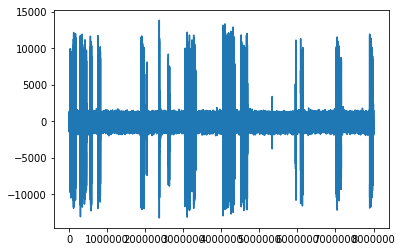

In [4]:
plt.plot(range(len(right)), right)

Plotting was subset of our data was pretty slow, but maybe plotting this many points is asking a lot of the plotting system. Let's try operating on the data. 

Consider normalizing the values to the range (0,1). The straightforward method is to iterate over each sample and center and scale each one:

In [5]:
%%time
normalized = []
for l,r in zip(left,right):
    l_normalized = (l + 2**8) / 2**16
    r_normalized = (r + 2**8) / 2**16
    normalized.append((l_normalized, r_normalized))
print(normalized[:5])
normalized = None

[(0.0030364990234375, 0.011444091796875), (0.000213623046875, 0.0064544677734375), (0.0007476806640625, 0.0101470947265625), (-0.001800537109375, 0.016845703125), (-0.0048675537109375, 0.0117645263671875)]
CPU times: user 3.15 s, sys: 262 ms, total: 3.41 s
Wall time: 3.42 s


So that is pretty slow and memory intensive, and we were operating on a subset of the data. 

There are several operations happening in a long loop, and each operation in Python comes with a pretty hefty overhead. Let's try a loop with less going on:

In [6]:
%%time
for i in range(10**8):
    pass

CPU times: user 3.26 s, sys: 2.93 ms, total: 3.27 s
Wall time: 3.28 s


This no-op loop takes several seconds to complete. Creating many small functions is great for maintainability but in a tight loop the overhead cost may be a consideration.

Using Numpy arrays will push the slower Python operations down into optimized C code. 

With a numpy array, we specify *vectorized* operations to run on the entire array or a subset of it and Numpy handles the rest.


## Creating numpy arrays

 - From array-like objects like lists: `np.array([3,4,5], dtype=np.uint32)`
 - Using numpy intrinsic functions such as
   - `np.zeros((4,4))`
   - `np.arange(0,1,0.1)`
   - `np.linspace(1., 4., 6)`
 - Initialize from binary streams: `np.frombuffer(b'\xde\xad\xbe\xef', dtype=np.uint8)`
 - Read from disk standard formats: netCDF, CSV
 - Read from disk numpy specific formats: `np.load('file.npz')`, or streaming a binary stream through a high speed compressor like [Blosc](http://python-blosc.blosc.org/) or [LZ4](https://pypi.org/project/lz4/)
 
Create a numpy array from our two Python lists:

In [7]:
import numpy as np
# create a numpy array from our two lists
stereo = np.array((left, right))
left = right = None
print(stereo, stereo.shape)

[[ -57 -242 -207 ...  181   46  132]
 [ 494  167  409 ...    4  -49 -358]] (2, 8000000)


Now let's write a vectorized version of our normalization loop above.

In [8]:
%%time
normalized = (stereo + (2**8)) / 2**16
print(normalized[:,:5])

[[ 0.0030365   0.00021362  0.00074768 -0.00180054 -0.00486755]
 [ 0.01144409  0.00645447  0.01014709  0.0168457   0.01176453]]
CPU times: user 90.7 ms, sys: 55.8 ms, total: 146 ms
Wall time: 146 ms


The Numpy version is more concise and about 20x faster. Now let's look at data access patterns.

## Indexing and Slicing

Indexing a 2-dimensional array with the list-of-lists we'd use in native Python looks like it would in the equivalent C code:
```
stereo[0][0]
```
Numpy has [many ways to index](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html) an array, and they all have one thing in common: they are contained within one set of brackets `[]` with dimensions separated by commas. For instance, to get the first value as above:
```
stereo[0,0]
```
The first method will work, but will defeat some Numpy benefits as indexes become fancier. There is indeed a class data of access patterns known as "fancy indexing". A major difference between the two is that "basic slicing" returns a view of the data while "fancy indexing" returns a copy.

Indexes on a dimension can be a slice to obtain a view of a subset of the data. let's get block of 10 samples of the 2nd channel:


In [9]:
# basic slicing shares memory
block = stereo[0, 100:110]
print(block, np.may_share_memory(stereo, block))

[-133  -81   50   12   56  164   55   61  193   46] True


In [10]:
# fancy (or advanced) indexing uses tuples as indexes so we can extract the data we want in the order we want.
# Let's pull a few samples and check if the memory is shared
samples = stereo[:,(10, 100, 200, 9000, 1, 0)]
print(samples, np.may_share_memory(stereo, samples))

[[-962 -133 -316  288 -242  -57]
 [ 720  182  365 -483  167  494]] False


## Masking
Select only the data meeting a boolean criteria:

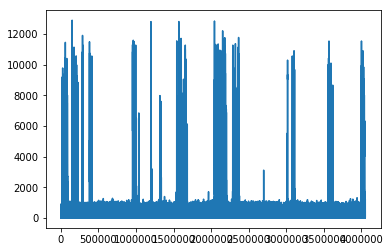

In [32]:
mask = stereo > 0
greater_than_zero = stereo[0, mask[0,:]]
plt.plot(greater_than_zero)


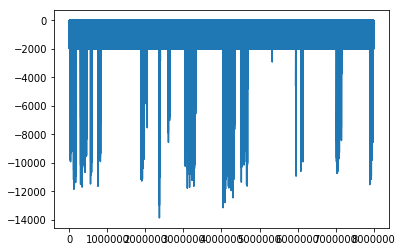

In [35]:
# set values at locations specified by the mask:
stereo[mask] = -2000
plt.plot(stereo[0, :])


## Slicing and broadcasting the third dimension

(3000, 3000, 3)


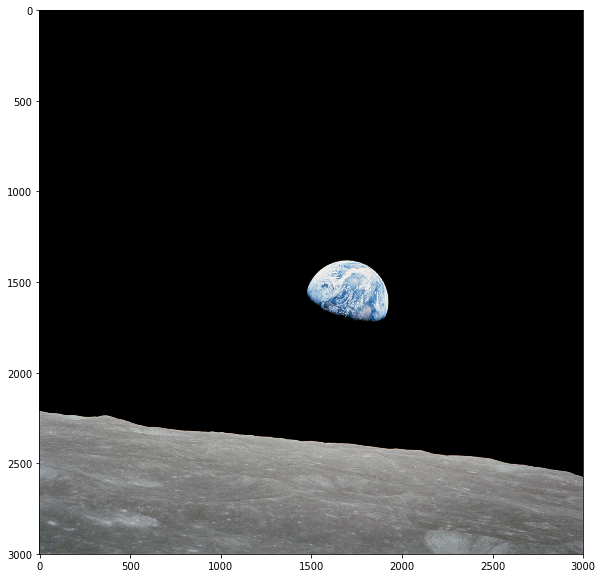

In [54]:
plt.figure(figsize = (10,10))
from src.data.image import earthrise
img = earthrise()
print(img.shape)
plt.imshow(img)

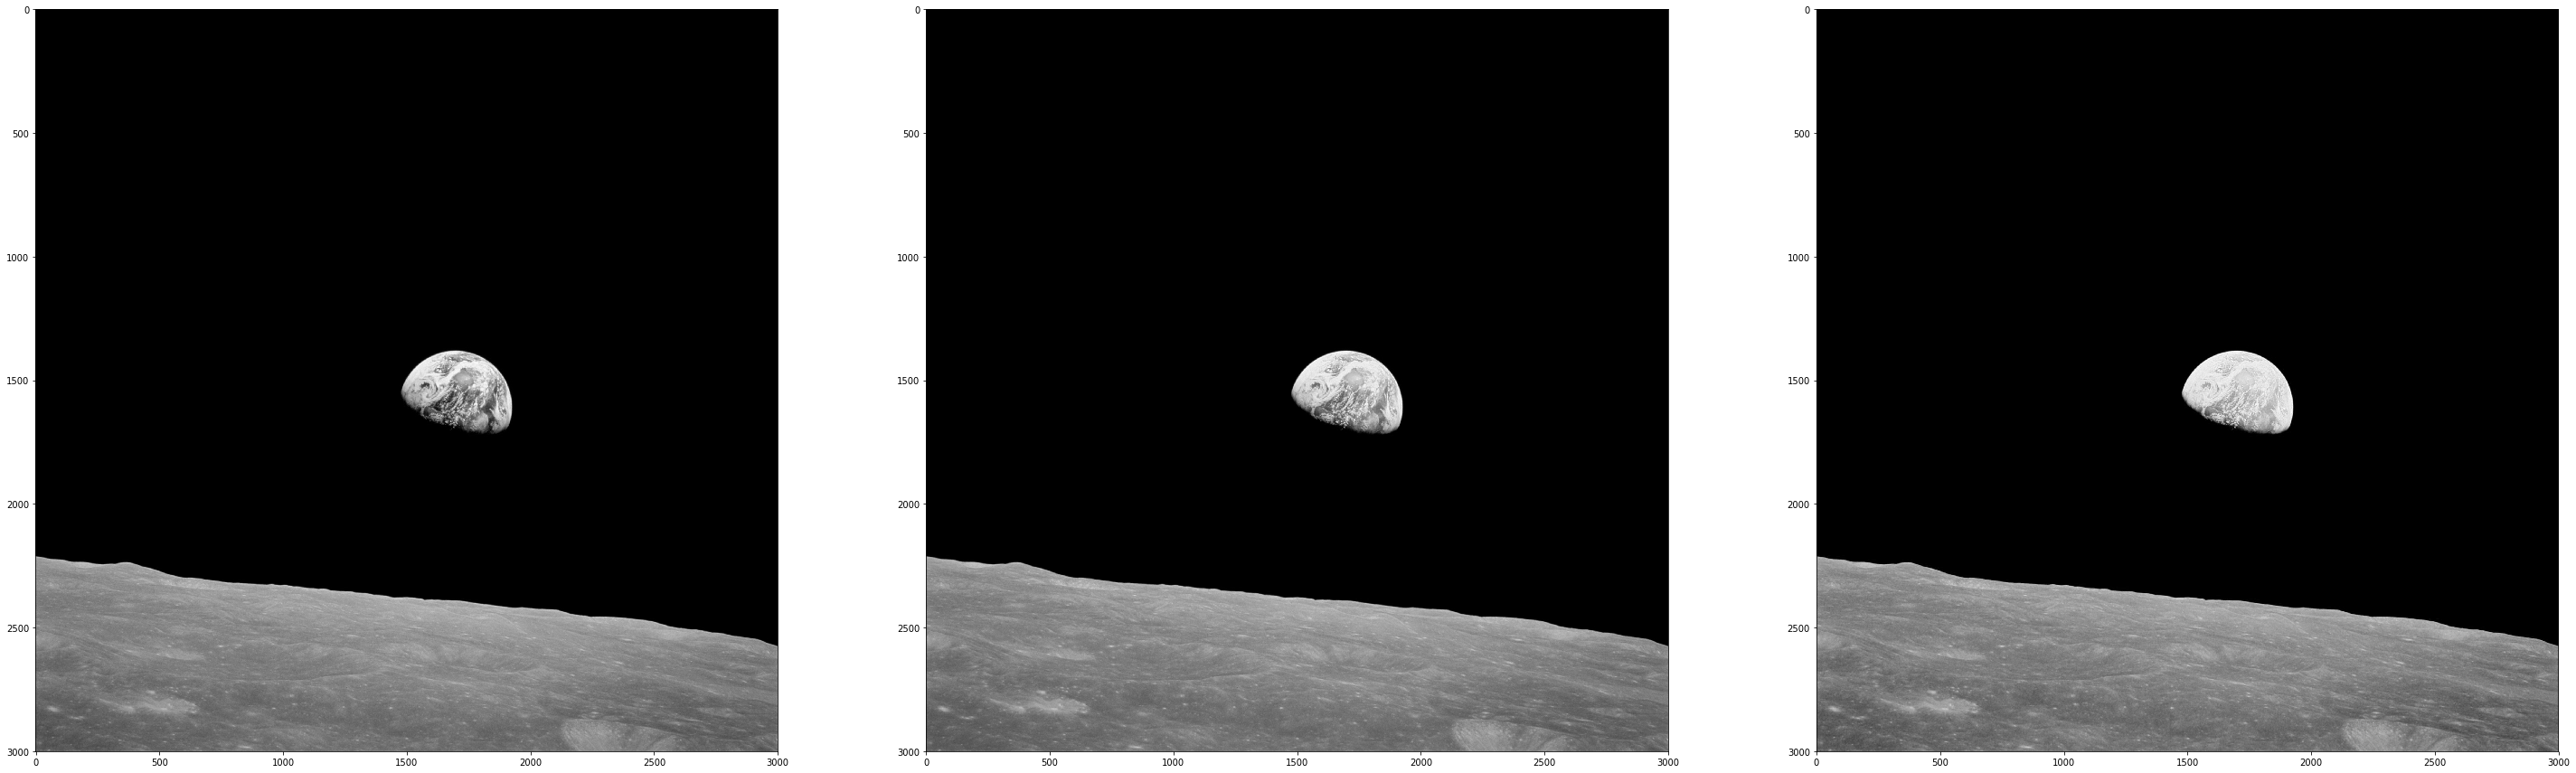

In [55]:
plt.figure(figsize = (50,50))
plt.subplot(131)
plt.imshow(img[:,:,0], cmap='gray')
plt.subplot(132)
plt.imshow(img[:,:,1], cmap='gray')
plt.subplot(133)
plt.imshow(img[:,:,2], cmap='gray')

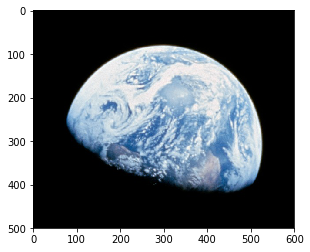

In [57]:
# crop out the earth and filter out just the ocean with some bogofilters

# crop the center x, y, and all 3 color channels
earth = img[1300:1800, 1400:2000, :]
plt.imshow(earth)

In [1]:
# get a view of each color channel
r = earth[:,:,0]
g = earth[:,:,1]
b = earth[:,:,2]

# set blue channel to zero where red and green are large
b[g > 150] = 0
b[r > 150] = 0
b[b < 100] = 0
# set red and green channels to 0
r[:,:] = 0
g[:,:] = 0

# add a pleasing turquoise border with broadcasting
turquoise = np.array([60, 200, 250]).T
earth[-30:,:,:] = turquoise
earth[:30,:,:] = turquoise
earth[:,:30,:] = turquoise
earth[:,-30:,:] = turquoise

plt.figure(figsize = (10,10))
plt.imshow(earth)

NameError: name 'earth' is not defined